# QAQC order and single function testing

## Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Import QAQC libraries

In [2]:
import os
import tempfile
import argparse 

# Import all qaqc script functions
try:
    from qaqc_plot import *
    from qaqc_utils import *
    from qaqc_wholestation import *
    from qaqc_logic_checks import *
    from qaqc_buoy_check import *
    from qaqc_frequent import *
    from qaqc_unusual_gaps import *
    from qaqc_unusual_large_jumps import *
    from qaqc_climatological_outlier import *
    from qaqc_unusual_streaks import *
except Exception as e:
    print("Error importing qaqc script: {}".format(e))

# Import qaqc stage calc functions
try:
    from QAQC_pipeline import *
except:
    print("Error importing QAQC_pipeline.py")
    
if not os.path.exists("./qaqc_figs"):
    os.makedirs("./qaqc_figs")

## Testing on a single network / station

### Load file and convert to pandas df 

In [3]:
""" Aqaqc_world_recordtions from QAQC libraries can be used here.
    For the qaqc pipeline, we need the pandas df in the same format used in it
"""

network = "VCAPCD"
rawdir, cleandir, qaqcdir, mergedir = get_file_paths(network)
print(rawdir)
print(cleandir)
print(qaqcdir)
print(mergedir)

1_raw_wx/VCAPCD/
2_clean_wx/VCAPCD/
3_qaqc_wx/VCAPCD/
4_merge_wx/VCAPCD/


In [4]:
""" We can test in the same way that the pipeline, 
    take a network and subsample an station
"""

files, stations = read_network_files(network, cleandir)
stations_sample = stations.sample(1)
station = stations_sample.iloc[0]
print(station)

VCAPCD_SU


In [5]:
""" We could load station files from the 
    s3 bucket
"""
file_name = cleandir + station + ".nc"
fs = s3fs.S3FileSystem()
aws_url = "s3://wecc-historical-wx/"+file_name

with fs.open(aws_url) as fileObj:
    t0 = time.time()
    ds = xr.open_dataset(fileObj).load()
    ds = ds.drop_duplicates(dim="time")

In [6]:
ds

<xarray.Dataset>
Dimensions:         (station: 1, time: 103124)
Coordinates:
  * time            (time) datetime64[ns] 2010-05-27T18:00:00 ... 2022-08-31T...
  * station         (station) object 'VCAPCD_SU'
    lat             (station, time) float64 34.29 34.29 34.29 ... 34.29 34.29
    lon             (station, time) float64 -118.8 -118.8 ... -118.8 -118.8
Data variables: (12/17)
    ps              (station, time) float64 9.856e+04 9.856e+04 ... 9.777e+04
    tas             (station, time) float64 286.9 286.9 286.9 ... 307.8 307.8
    pr              (station, time) float64 nan nan nan nan ... nan nan nan nan
    hurs            (station, time) float64 80.5 86.1 87.1 ... 21.0 20.0 20.0
    rsds            (station, time) float64 123.0 278.0 215.0 ... 805.0 675.0
    sfcWind         (station, time) float64 0.7 2.2 1.4 ... 4.296 4.198 4.398
    ...              ...
    sfcWind_dir_qc  (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    pr_1h           (station, time) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    pr_1h_qc        (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    rsds_qc         (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    tdps_derived    (station, time) float64 283.5 284.6 284.7 ... 281.8 281.8
    elevation       (station, time) float64 288.0 288.0 288.0 ... 288.0 288.0
Attributes: (12/13)
    title:                  VCAPCD cleaned
    institution:            Eagle Rock Analytics / Cal Adapt
    source:                 
    history:                MADIS_clean.py script run on 02-07-2023, 15:02:12...
    comment:                Intermediate data product: may not have been subj...
    license:                
    ...                     ...
    disclaimer:             This document was prepared as a result of work sp...
    station_name:           Simi Valley - Upper Air
    raw_files_merged:       2
    anemometer_height_m:    nan
    thermometer_height_m:   nan
    barometer_elevation_m:  nan

In [7]:
""" Or we can test on a locally stored station 
    file directly
"""
ds = xr.open_dataset('Train_Files/LOXWFO_OX1MB.nc')
ds

<xarray.Dataset>
Dimensions:         (station: 1, time: 247300)
Coordinates:
  * time            (time) datetime64[ns] 2006-05-08T19:45:00 ... 2022-08-31T...
  * station         (station) object 'LOXWFO_OX1MB'
    lat             (station, time) float64 ...
    lon             (station, time) float64 ...
Data variables: (12/13)
    ps              (station, time) float64 ...
    tas             (station, time) float64 ...
    pr              (station, time) float64 ...
    hurs            (station, time) float64 ...
    sfcWind         (station, time) float64 ...
    sfcWind_dir     (station, time) float64 ...
    ...              ...
    hurs_qc         (station, time) object ...
    sfcWind_qc      (station, time) object ...
    sfcWind_dir_qc  (station, time) object ...
    pr_qc           (station, time) object ...
    tdps_derived    (station, time) float64 ...
    elevation       (station, time) float64 ...
Attributes: (12/13)
    title:                  LOXWFO cleaned
    institution:            Eagle Rock Analytics / Cal Adapt
    source:                 
    history:                MADIS_clean.py script run on 01-31-2023, 22:05:43...
    comment:                Intermediate data product: may not have been subj...
    license:                
    ...                     ...
    disclaimer:             This document was prepared as a result of work sp...
    station_name:           Morro Bay Harbor
    raw_files_merged:       1
    anemometer_height_m:    nan
    thermometer_height_m:   nan
    barometer_elevation_m:  nan

In [15]:
""" Then, the idea is to convert to pandas df in the 
    format needed for the qaqc pipeline
"""
df, MultiIndex, attrs, var_attrs = qaqc_ds_to_df(ds)
df.head(5)

,time,ps,tas,pr,hurs,sfcWind,sfcWind_dir,tas_qc,hurs_qc,sfcWind_qc,...,tas_eraqc,pr_eraqc,hurs_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,tdps_derived_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m,station
0,2006-05-08 19:45:00,NaN,285.93,NaN,68.92,3.60,290.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOXWFO_OX1MB
1,2006-05-08 20:45:00,NaN,285.93,NaN,NaN,4.12,300.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOXWFO_OX1MB
2,2006-05-08 21:45:00,NaN,285.93,NaN,NaN,5.66,300.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOXWFO_OX1MB
3,2006-05-08 23:45:00,NaN,286.48,NaN,NaN,7.20,300.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOXWFO_OX1MB
4,2006-05-09 00:45:00,NaN,285.93,NaN,66.34,6.69,300.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOXWFO_OX1MB


### Test QAQC pipeline of single functions

After converting to df in the same format than the pipeline, we could test the whole pipeline, or single functions

#### Testing single functions

In [9]:
new_df = df.copy()

In [10]:
new_df = qaqc_world_record(new_df)

In [11]:
new_df = qaqc_elev_range(new_df)

Elevation values post-infilling/correcting: [6.096]
Elevation qaqc values post-infilling/correcting: [nan]


In [12]:
new_df = qaqc_unusual_repeated_streaks(new_df, plot=True, local=True, verbose=True)

tas
tdps_derived
ps
sfcWind
Running qaqc_unusual_repeated_streaks on ['tas', 'tdps_derived', 'ps', 'sfcWind']


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_plot.py:629: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(miny,maxy)


In [ ]:
new_df = qaqc_climatological_outlier(new_df, plot=True, verbose=True)

#### Testing the whole pipeline

In [13]:
# Set up error handling.
errors, end_api, timestamp = setup_error_handling()

In [14]:
df, attrs, var_attrs = run_qaqc_pipeline(ds, network, file_name, errors, 
                                         station, end_api, rad_scheme="remove_zeros",
                                         verbose=True, local=True)

Updating missing values for: ps
Updating missing values for: tas
Updating missing values for: pr
Updating missing values for: hurs
Updating missing values for: sfcWind
Updating missing values for: sfcWind_dir
Updating missing values for: tdps_derived
pass qaqc_missing_vals
pass qaqc_missing_latlon
pass qaqc_within_wecc
Elevation values pre-infilling: [6.096]
Elevation eraqc values pre-infilling: [nan]
Elevation values post-infilling/correcting: [6.096]
Elevation qaqc values post-infilling/correcting: [nan]
pass qaqc_elev_range
Thermometer height is missing -- air temperature will be excluded from all QA/QC checks
pass qaqc_sensor_height_t
Anemometer height is missing -- wind speed and direction will be excluded from all QA/QC checks
pass qaqc_sensor_height_w
pass qaqc_world_record
tdps_derived eraqc flags (any other value than nan is an active flag!): [nan 11.]
pass qaqc_crossvar_logic_tdps_to_tas_supersat
pass qaqc_crossvar_logic_tdps_to_tas_wetbulb
Precip range:  0.0 - 16620.744
Prec

NameError: name 'attrs' is not defined

In [ ]:
### Or we can always run the same way that the ALL_NETWORKS_qaqc.py does:
# whole_station_qaqc(network, cleandir, qaqcdir, rad_scheme="remove_zeros", 
#                    verbose=True, local=True)

In [3]:
""" Aqaqc_world_recordtions from QAQC libraries can be used here.
    For the qaqc pipeline, we need the pandas df in the same format used in it
"""

network = "ASOSAWOS"
rawdir, cleandir, qaqcdir, mergedir = get_file_paths(network)
print(rawdir)
print(cleandir)
print(qaqcdir)
print(mergedir)

1_raw_wx/ASOSAWOS/
2_clean_wx/ASOSAWOS/
3_qaqc_wx/ASOSAWOS/
4_merge_wx/ASOSAWOS/


In [4]:
""" We can test in the same way that the pipeline, 
    take a network and subsample an station
"""

files, stations = read_network_files(network, cleandir)
stations_sample = stations.sample(1)
station = stations_sample.iloc[0]
print(station)

ASOSAWOS_72038800469


In [6]:
pwd

'/Users/hector/ERA_work/PARALLEL/historical-obs-platform/test_platform/scripts/3_qaqc_data'

- ASOSAWOS_74718503144
- ASOSAWOS_74917900392 

In [7]:
""" Or we can test on a locally stored station 
    file directly
"""
ds = xr.open_dataset('Train_Files/ASOSAWOS_74718503144.nc')
ds

<xarray.Dataset>
Dimensions:          (station: 1, time: 155803)
Coordinates:
  * time             (time) datetime64[ns] 2006-01-01T00:53:00 ... 2022-08-31...
    lat              (station, time) float64 ...
    lon              (station, time) float64 ...
  * station          (station) object 'ASOSAWOS_74718503144'
Data variables: (12/21)
    ps               (station, time) float64 ...
    tas              (station, time) float64 ...
    tdps             (station, time) float64 ...
    pr               (station, time) float64 ...
    sfcWind          (station, time) float64 ...
    sfcWind_dir      (station, time) float64 ...
    ...               ...
    pr_qc            (station, time) object ...
    pr_duration      (station, time) timedelta64[ns] ...
    pr_depth_qc      (station, time) float64 ...
    sfcWind_qc       (station, time) object ...
    sfcWind_method   (station, time) object ...
    sfcWind_dir_qc   (station, time) object ...
Attributes: (12/19)
    title:                 ASOS/AWOS cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               ASOSAWOS_clean.py script run on 02-06-2023, 23:43:...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    GHCN-DailyID:          USW00003144
    Networks:              ASOS
    thermometer_height_m:  nan
    anemometer_height_m:   10.06
    barometer_elev_m:      -14.63
    raw_files_merged:      17

In [8]:
# ds.ps_altimeter.plot()

In [9]:
""" Then, the idea is to convert to pandas df in the 
    format needed for the qaqc pipeline
"""
df, MultiIndex, attrs, var_attrs = qaqc_ds_to_df(ds)
df.head(2)

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,pr_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,pr_duration_eraqc,anemometer_height_m,thermometer_height_m,station
0,2006-01-01 00:53:00,101280.0,292.55,279.85,0.0,10.8,240.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144
1,2006-01-01 01:53:00,101310.0,292.05,281.45,0.0,4.1,270.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144


In [10]:
new_df = qaqc_unusual_large_jumps(df, plot=True, local=True, verbose=True)

NameError: name 'log_file' is not defined

In [12]:
new_df = qaqc_unusual_repeated_streaks(df, plot=True, local=True, verbose=True)

tas
tdps
ps
psl
sfcWind
Running qaqc_unusual_repeated_streaks on ['tas', 'tdps', 'ps', 'psl', 'sfcWind']


Running qaqc_unusual_large_jumps on ['tas', 'tdps', 'ps', 'psl', 'ps_altimeter']
Running unusual large jumps check on: tas
Running unusual large jumps check on: tdps
Running unusual large jumps check on: ps
Running unusual large jumps check on: psl
Running unusual large jumps check on: ps_altimeter
qaqc_unusual_large_jumps failed with Exception: 'ps_altimeter'


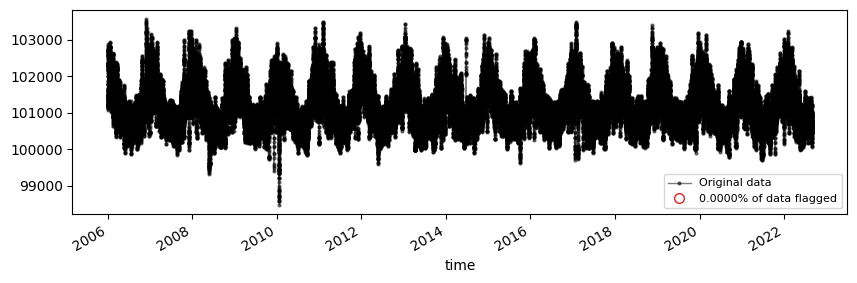

In [13]:
new_df = qaqc_unusual_large_jumps(new_df, plot=True, local=True, verbose=True)